EL NOTEBOOK PRESENTE BUSCA ENTRENAR UNA RED NEURONAL CONVOLUCIONAL PARA DETECTAR SEÑALETICAS VIALES DEL ESTADO DE CHILE

-CHST

In [69]:
import os                   #Se importan funcionalidades del sistema operativo
import tensorflow as tf     #Librería TensorFlow (GPU: ON)
import numpy as np          #Librería para manejo de matrices
import cv2                  #Importar imagenes, reajustarla, etc.
import random               
from tqdm import tqdm       #Librería 100%|██████████████████████████████████████████████████████████████████████████████████| 

print(tf.__version__)
dir_img_señaleticas = "D:/kaggle/disco pare/imagenes_sign"
dir_test_img = "D:/kaggle/disco pare/test"
lr = 1e-3 
ancho = 400
alto = 400
canales = 1

NOMBRE_MODELO = '23-09-2018-V3-{}-{}.model'.format(lr, 'CNN')

1.8.0


In [70]:
from PIL import Image
#Image.save(fp, format=None, **params)
def rotar_imagenes(ruta, anugloInicial, anguloFinal, cantidad):
    angulo = (anguloFinal - anugloInicial)/cantidad
    contador = 30
    for img in tqdm(os.listdir(ruta)):
        nombre = img.split('.')[1]
        path = os.path.join(dir_img_señaleticas,img)
        im = Image.open(path)
        for i in range(cantidad):
            rotacion = anugloInicial + i * angulo
            rotar = im.rotate(rotacion)
            rotar.save("{}.{}.jpg".format(contador,nombre))
            contador+=1
            
#rotar_imagenes(dir_img_señaleticas,-90,90,90)       

In [71]:
def ajustar_nombres():
    for i,img in tqdm(enumerate(os.listdir(dir_img_señaleticas))):
        #numero.nombre.formato
        nombre = str(i) + "." + img.split('.')[1] + ".jpg"
        os.rename(img, str(nombre))
        

def etiquetas(nombre): #Así, si es que hay más señaleticas, se puede agrandar facilmente.
    if nombre == "DISCO_PARE":
        return [1,0]
    if nombre == "CEDA_EL_PASO":
        return [0,1]
        
def entrenamientoImagenes():
    datos_entrenamiento=[]
    for i in tqdm(os.listdir(dir_img_señaleticas)):
        etiqueta = etiquetas(i.split(".")[1])
        ruta_completa = os.path.join(dir_img_señaleticas,i) #D:\img\disco pare\imagenes_señaleticas\imagen
        #img = cv2.imread(ruta_completa)
        img = cv2.imread(ruta_completa,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (ancho,alto))
        datos_entrenamiento.append([np.array(img),np.array(etiqueta)])
    random.shuffle(datos_entrenamiento)
    return datos_entrenamiento

def crear_datos_test():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])  
    shuffle(testing_data)
    np.save('datos_de_test.npy', testing_data)
    return testing_data


In [72]:
imagenes_entrenamiento = entrenamientoImagenes()
print(len(imagenes_entrenamiento))
# Si ya tengo los datos:
#imagenes_entrenamiento = np.load('datos_de_test.npy')

100%|██████████████████████████████████████████████████████████████████████████████| 2222/2222 [02:44<00:00, 13.53it/s]


2222


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [75]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

tf.reset_default_graph()

convnet = input_data(shape=[None, ancho, alto, canales], name='input')
#                 (tensor, numero de kernels, tamaño de kernel, funcion de activacion )
# 
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 3, activation='relu')
convnet = max_pool_2d(convnet, 3)

convnet = conv_2d(convnet, 128, 3, activation='relu')
convnet = max_pool_2d(convnet, 3)

convnet = conv_2d(convnet, 64, 3, activation='relu')
convnet = max_pool_2d(convnet, 3)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=lr, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet,tensorboard_verbose=3,tensorboard_dir='log')



In [77]:
entrenamiento = imagenes_entrenamiento[:-666]
print(len(entrenamiento))
prueba = imagenes_entrenamiento[-666:]
len(prueba)

1556


666

In [78]:
#Guardare las imagenes transfdormadas en array en X, y en Y las etiquetas correspondientes
X = np.array([i[0] for i in entrenamiento]).reshape(-1,ancho,alto,1)
Y = [ i[1] for i in entrenamiento] 

test_x = np.array([i[0] for i in prueba]).reshape(-1,ancho,alto,1)
test_y = [i[1] for i in prueba]

In [79]:
model.fit({'input': X}, {'targets': Y}, n_epoch=8,validation_set=({'input': test_x}, {'targets': test_y}),
          snapshot_step=1500, show_metric=True, run_id=NOMBRE_MODELO, batch_size=20)


Training Step: 623  | total loss: 0.08390 | time: 441.698s
| Adam | epoch: 008 | loss: 0.08390 - acc: 0.9936 -- iter: 1540/1556
Training Step: 624  | total loss: 0.09280 | time: 448.803s
| Adam | epoch: 008 | loss: 0.09280 - acc: 0.9893 | val_loss: 0.00165 - val_acc: 1.0000 -- iter: 1556/1556
--


In [80]:
model.save(NOMBRE_MODELO)

INFO:tensorflow:C:\Users\crist\23-09-2018-V3-0.001-CNN.model is not in all_model_checkpoint_paths. Manually adding it.


In [81]:
dir_test = "D:/kaggle/disco pare/test"
def crear_datos_test():
    testing_data = []
    for img in tqdm(os.listdir(dir_test)):
        ruta = os.path.join(dir_test,img)
        img_num = img.split('.')[0]
        img = cv2.imread(ruta,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (ancho,alto))
        testing_data.append([np.array(img), img_num])  
    random.shuffle(testing_data)
    np.save('datos_prueba.npy', testing_data)
    return testing_data

In [17]:
import matplotlib.pyplot as plt

test_data = crear_datos_test()
#test_data = np.load('datos_de_entrenamiento.npy')

fig=plt.figure(figsize=(ancho,alto))

for num,data in enumerate(test_data[:]):
    img_num = data[1]
    img_imagen = data[0]
    
    y = fig.add_subplot(32,3,num+1)
    orig = img_imagen
    data = img_imagen.reshape(ancho,alto,canales)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='CEDA'
    else: str_label='DISCO'
        
    y.imshow(img_imagen, cmap='gray')
    plt.title(str_label,fontsize=100)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:18<00:00,  5.03it/s]


In [26]:
#Funcion que de prueba

def test_sign():
    for img in tqdm(os.listdir(dir_test_img)):
        ruta = os.path.join(dir_test,img)
        img_nombre = img.split('.')[0]
        img1 = cv2.imread(ruta,cv2.IMREAD_GRAYSCALE)
        img1 = cv2.resize(img1, (ancho,alto))
        img1 = np.array(img1).reshape(ancho,alto,1)
        if np.argmax(model.predict([img1])[0]) == 0:
            print("La imagen: {} es: DISCO PARE".format(img))
        else:
            print("La imagen: {} es: CEDA EL PASO".format(img))
test_sign()


  0%|                                                                                           | 0/95 [00:00<?, ?it/s]

La imagen: 1.d.jpg es: DISCO PARE


  1%|▊                                                                                  | 1/95 [00:00<00:21,  4.29it/s]

La imagen: 10.c.jpg es: CEDA EL PASO
La imagen: 11.d.jpg es: CEDA EL PASO


  3%|██▌                                                                                | 3/95 [00:00<00:15,  5.80it/s]

La imagen: 12.d.jpg es: CEDA EL PASO


  4%|███▍                                                                               | 4/95 [00:00<00:17,  5.24it/s]

La imagen: 13.c.jpg es: CEDA EL PASO
La imagen: 14.c.jpg es: CEDA EL PASO
La imagen: 15.c.jpg es: CEDA EL PASO
La imagen: 17.d.jpg es: DISCO PARE


  8%|██████▉                                                                            | 8/95 [00:01<00:11,  7.45it/s]

La imagen: 19d.jpg es: DISCO PARE


  9%|███████▊                                                                           | 9/95 [00:01<00:12,  6.89it/s]

La imagen: 20180810_131128.d.jpg es: CEDA EL PASO


 11%|████████▋                                                                         | 10/95 [00:01<00:12,  6.75it/s]

La imagen: 20180810_131130.jpg es: CEDA EL PASO


 12%|█████████▍                                                                        | 11/95 [00:01<00:12,  6.59it/s]

La imagen: 20180810_131135.jpg es: CEDA EL PASO


 13%|██████████▎                                                                       | 12/95 [00:01<00:12,  6.54it/s]

La imagen: 20180810_131138.jpg es: DISCO PARE


 14%|███████████▏                                                                      | 13/95 [00:02<00:12,  6.44it/s]

La imagen: 20180810_131142.jpg es: CEDA EL PASO


 15%|████████████                                                                      | 14/95 [00:02<00:12,  6.42it/s]

La imagen: 20180810_131147.jpg es: CEDA EL PASO


 16%|████████████▉                                                                     | 15/95 [00:02<00:12,  6.36it/s]


KeyboardInterrupt: 

In [29]:
print(NOMBRE_MODELO)
if os.path.exists('C:/Users/crist/Desktop/Tensorflow/{}.meta'.format(NOMBRE_MODELO)):
    model.load(NOMBRE_MODELO)
    print('MODELO CARGADO!')

disco-pare-y-ceda-el-paso-02-07-2018-V11-0.001-CNN.model


In [84]:
test_data = crear_datos_test()
len(test_data)

100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:16<00:00,  5.84it/s]


94

Probabilidad de Disco Pare:  1.0
Probabilidad de Ceda el Paso:  2.8284188e-09
Probabilidad de Disco Pare:  1.0
Probabilidad de Ceda el Paso:  3.5512843e-11
Probabilidad de Disco Pare:  0.010542946
Probabilidad de Ceda el Paso:  0.9894571
Probabilidad de Disco Pare:  0.13627283
Probabilidad de Ceda el Paso:  0.86372715
Probabilidad de Disco Pare:  0.9986166
Probabilidad de Ceda el Paso:  0.0013833769
Probabilidad de Disco Pare:  0.7493168
Probabilidad de Ceda el Paso:  0.2506832
Probabilidad de Disco Pare:  0.9999999
Probabilidad de Ceda el Paso:  6.996029e-08
Probabilidad de Disco Pare:  0.3014278
Probabilidad de Ceda el Paso:  0.6985722
Probabilidad de Disco Pare:  0.08964899
Probabilidad de Ceda el Paso:  0.91035104
Probabilidad de Disco Pare:  0.9994747
Probabilidad de Ceda el Paso:  0.0005253595
Probabilidad de Disco Pare:  0.30121997
Probabilidad de Ceda el Paso:  0.69878
Probabilidad de Disco Pare:  0.006651489
Probabilidad de Ceda el Paso:  0.99334854
Probabilidad de Disco Pare:

ValueError: num must be 1 <= num <= 90, not 91

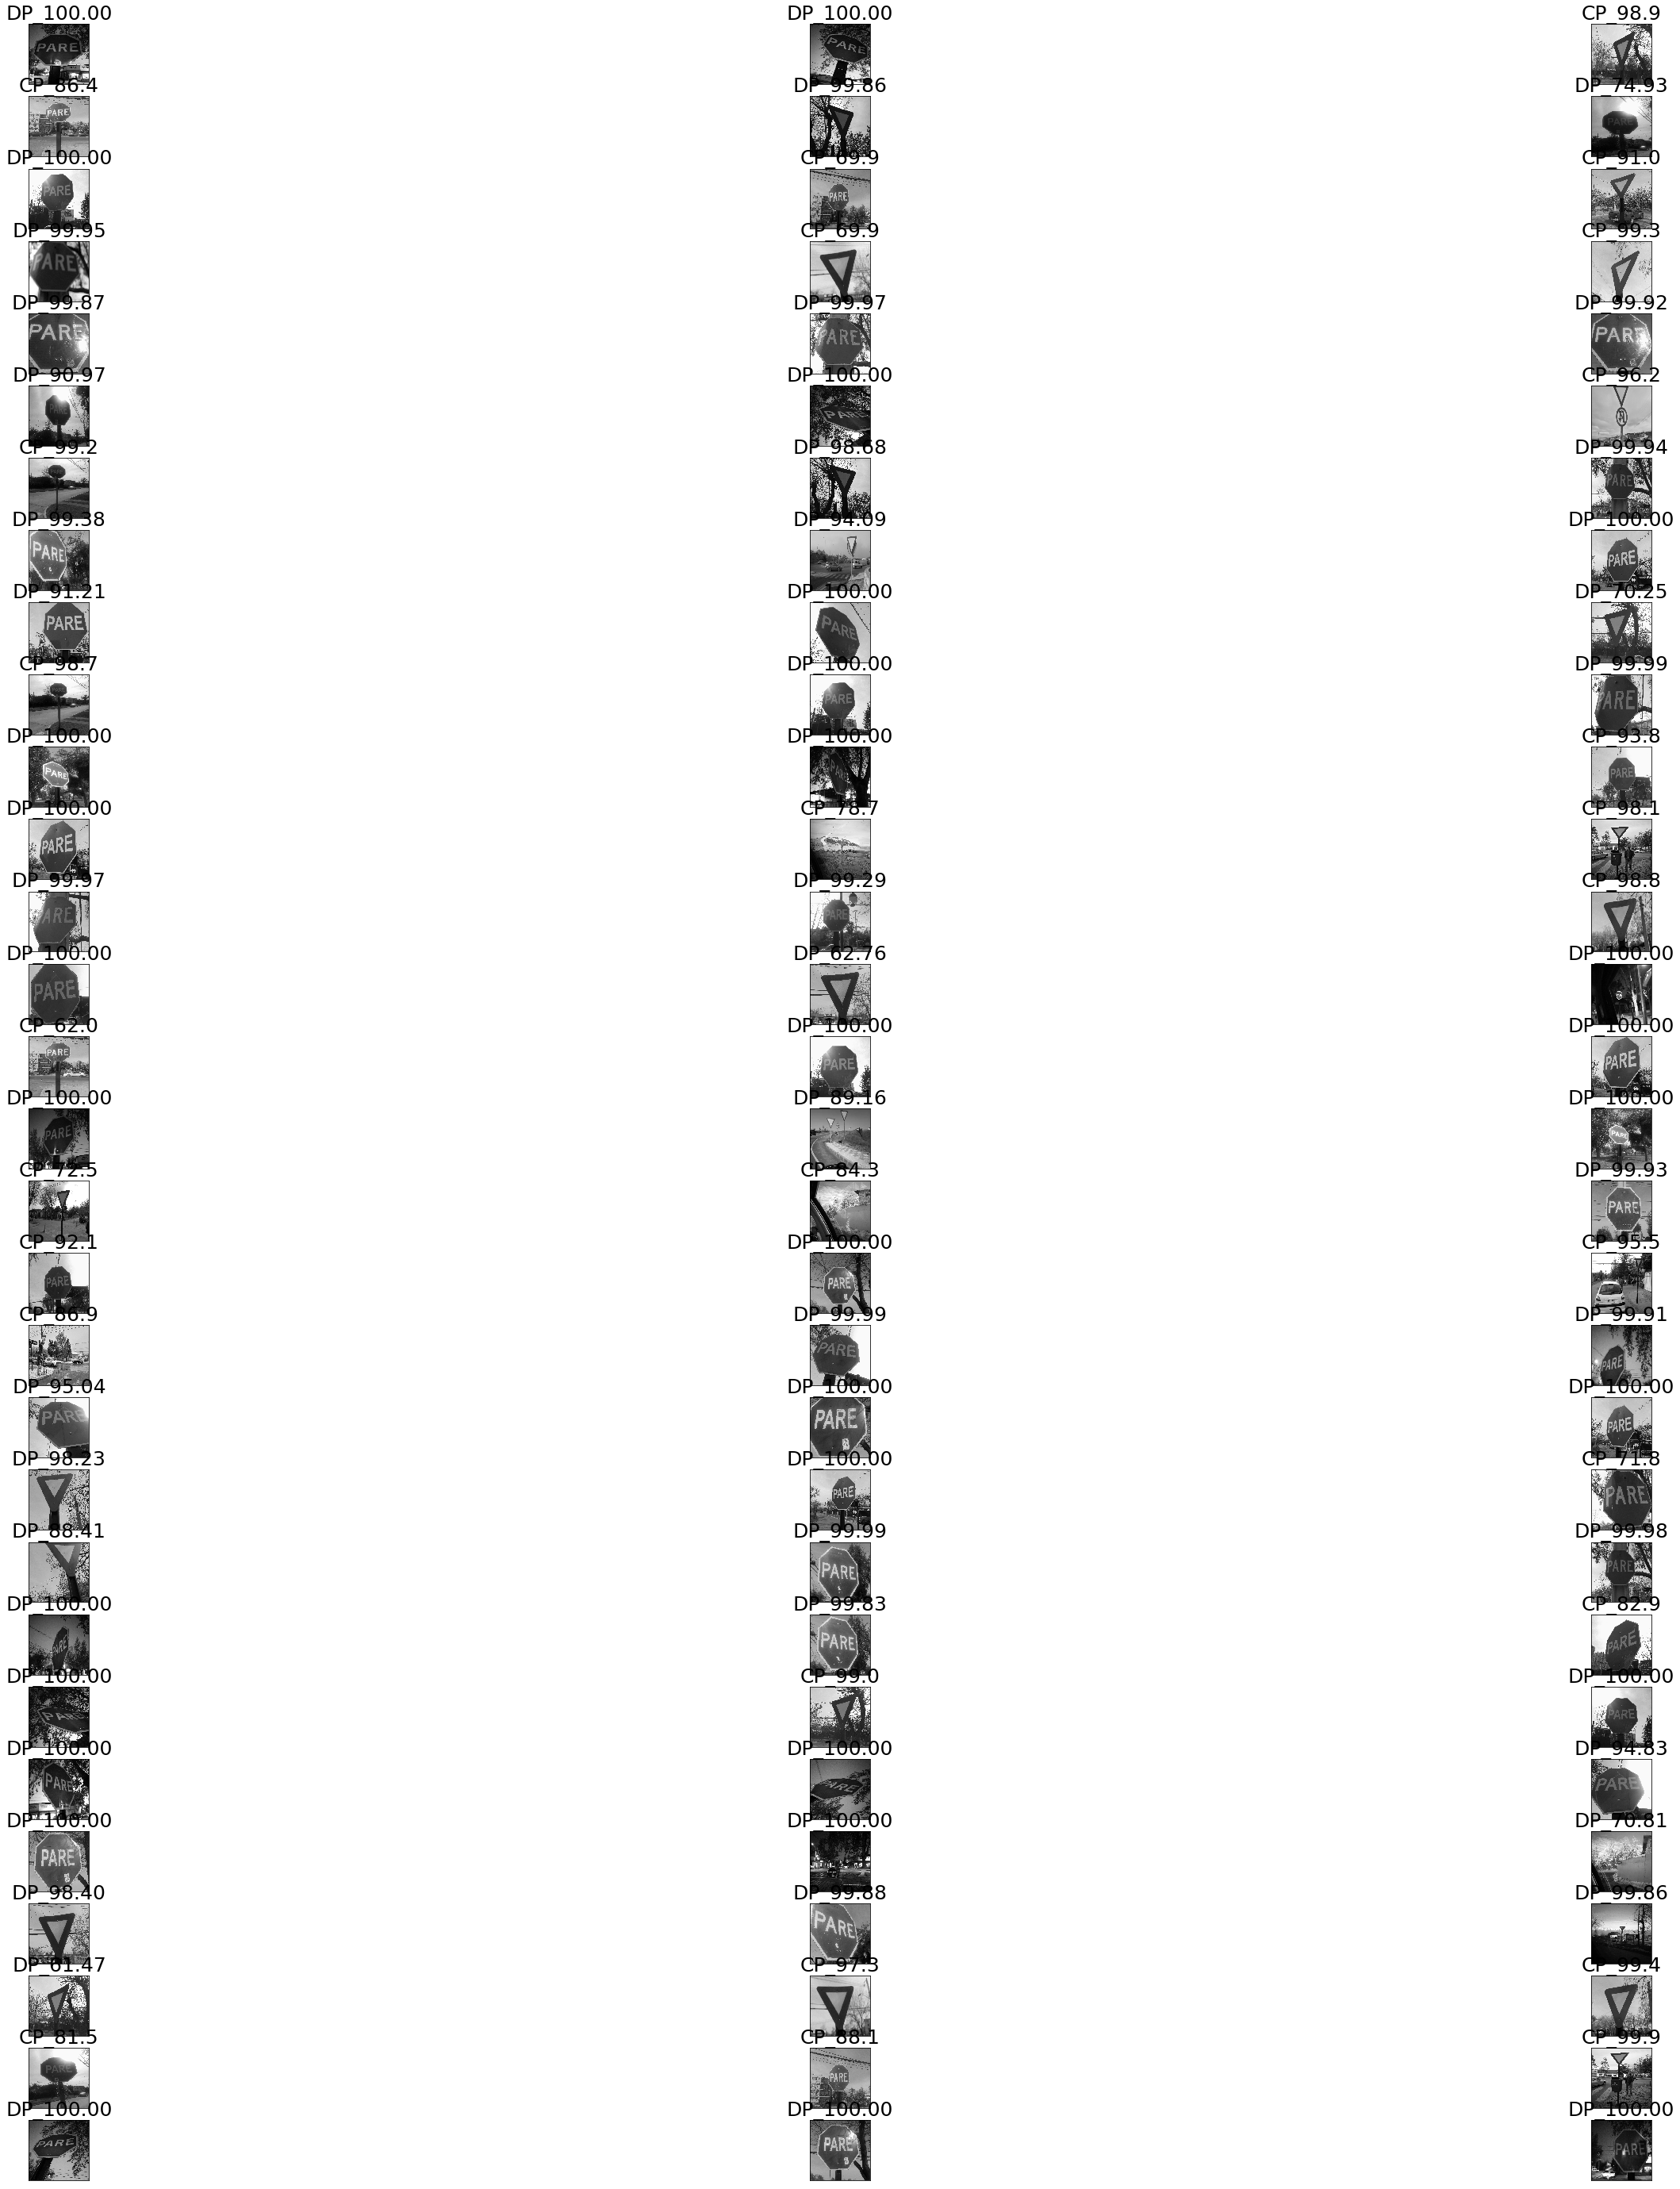

In [87]:
import matplotlib.pyplot as plt

IMG_SIZE2 = 50
fig=plt.figure(figsize=(IMG_SIZE2,IMG_SIZE2))

for num,data in enumerate(test_data[:]):
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(30,3,num+1)
    orig = img_data
    data = img_data.reshape(ancho,alto,canales)
    #print(data)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    print('Probabilidad de Disco Pare: ',model_out[0])
    print('Probabilidad de Ceda el Paso: ',model_out[1])
    
    if np.argmax(model_out) == 1: str_label='CP_{0:.1f}'.format(model_out[1]*100)
    else: str_label='DP_{0:.2f}'.format(model_out[0]*100)
        
    y.imshow(img_data,cmap='gray')
    plt.title(str_label,fontsize=25)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()